In [25]:
from abc import ABC, abstractmethod
import numpy as np
import random
import matplotlib.pyplot as plt

### GridWorld using Value Iteration: In this example, we will use value iteration to obtain the Q/value -function for the GridWorld problem and extract a policy

In [345]:
# first, define an interface for an MDP
class MDP:
    @abstractmethod
    def get_states(self):
        pass   

    @abstractmethod
    def get_initial_state(self):
        pass

    @abstractmethod
    def get_terminal_states(self):
        pass    

    @abstractmethod
    def get_actions(self, state):
        pass

    @abstractmethod
    def get_transitions(self, state, action):
        pass

    @abstractmethod
    def get_rewards(self, state, action, next_state):
        pass

    @abstractmethod
    def is_terminal(self, state):
        pass

    @abstractmethod
    def get_discount_factor(self):
        pass
    
    @abstractmethod
    def execute(self):
        pass



# now, implement the gridworld problem MDP
class GridWorld(MDP):

    def __init__(self, discount_factor=0.9) :

        # initialise the set of all possible states, in this case tuples (x,y) of all grid cells, excluding walls
        # will use the example from lectures and tute week 7
        self.width = 4
        self.height = 3
 
        # specify walls/blocked states
        self.walls = [(1,1)]
 
        # specify terminal states
        self.terminal_states=[(3,1),(3,2)] 

        # create a dummy terminal state which is the successor to all terminal states
        self.exit = (-1,-1)

        # specify initial state
        self.initial_state = (0,0)

        # list of all allowed states
        self.states = [self.exit]
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) not in self.walls:
                   self.states.append((x,y))

        # specify probability of splipping
        self.noise = 0.1

        # specify/enumerate the actions
        self.terminate = 0
        self.up = 1
        self.down = 2
        self.left = 3
        self.right = 4
        self.action_names = {self.up : 'up', self.down : 'down', self.left: 'left', self.right : 'right', self.terminate: 'end'}
        
        # set the discount factor
        self.gamma = discount_factor

        # specify rewards
        self.rewards =  {(3,1) : -1, (3,2) : 1}

        # specify action cost 
        self.action_cost = 0.0

        # initialize Q-function and value function
        self.Q = {}
        self.V = {}
        self.Vtemp = {}
        for state in (self.states):
            self.V[state] = 0.0
            self.Vtemp[state] = 0.0
            actions = self.get_actions(state)
            for action in actions:
                self.Q[(state, action)] = 0.0     


    def get_states(self):
        return self.states   


    def get_initial_state(self):
        return self.initial_state


    def get_terminal_states(self):
        return self.terminal_states


    def get_actions(self, state):

        actions = [self.terminate, self.up, self.down, self.left, self.right]
        if state is None:
            return actions
        
        valid_actions = []
        for action in actions:
            for (next_state, probability) in self.get_transitions(state, action):
                if probability > 0:
                    valid_actions.append(action)
                    break
                
        return valid_actions        

    
    # for given state-action pair, returns possible successor states along with their corresponding transition probabilities
    def get_transitions(self, state, action):
        
        # probability of not slipping
        straight = 1 - 2*self.noise

        transitions = []
        (x,y) = state


        # if in terminal state or exit state, then only the 'terminate' action is available        
        if state in self.terminal_states or state == self.exit:
            if action == self.terminate:
                return [(self.exit, 1.0)] 
            else:
                return []

        # for non-terminal states only up,down,left,right actions avaialable
        elif action == self.up:
            transitions.append(self.valid_add(state, (x,y+1), straight))
            transitions.append(self.valid_add(state, (x-1,y), self.noise))
            transitions.append(self.valid_add(state, (x+1,y), self.noise))

        elif action == self.down:
            transitions.append(self.valid_add(state, (x,y-1), straight))
            transitions.append(self.valid_add(state, (x-1,y), self.noise))
            transitions.append(self.valid_add(state, (x+1,y), self.noise))

        elif action == self.left:
            transitions.append(self.valid_add(state, (x-1,y), straight))
            transitions.append(self.valid_add(state, (x,y-1), self.noise))
            transitions.append(self.valid_add(state, (x,y+1), self.noise))

        elif action == self.right:
            transitions.append(self.valid_add(state, (x+1,y), straight))
            transitions.append(self.valid_add(state, (x,y-1), self.noise))
            transitions.append(self.valid_add(state, (x,y+1), self.noise))

        return transitions
    

    def get_rewards(self, state, action, next_state):
        # transitioning to the exit state will earn the non-zero rewards
        if (state in self.terminal_states) and (next_state == self.exit):
            reward = self.rewards[state]
        else:
            reward = self.action_cost

        return reward    


    def is_exit(self, state):
        return (state == self.exit)    


    def get_discount_factor(self):
        return self.gamma  

    
    def execute(self, state, action):
        # get all transitions
        transitions = self.get_transitions(state, action)
        states = [tr[0] for tr in transitions]
        probs = [tr[1] for tr in transitions]
        # sample from the transitions to get the next state state
        next_state = random.choices(states, weights=probs, k=1)[0]
        reward = self.get_rewards(state, action, next_state)
        return (next_state, reward)
    

    def valid_add(self, state, next_state, probability):

        # check if next state is a wall
        if next_state in self.walls:
            return (state, probability)

        # check if next state is off grid
        (x,y) = next_state
        if (x>=0 and x<=(self.width-1) and y>=0 and y<=(self.height-1)):
            return (next_state, probability)
        else:
            return (state, probability)


    def update_Q(self, state, action, Qnew):
        self.Q[(state, action)] = Qnew
    
    
    def update_V(self):
        # copy from Vtemp
        for state in self.states:
            self.V[state] = self.Vtemp[state]


    def update_V_from_Q(self):
        for state in self.states:
            actions = self.get_actions(state)
            self.V[state] =  max([self.Q[(state, action)] for action in actions])


    def extract_policy(self):
        # extract a policy using the Q function
        policy = {}
        for state in self.states:
            actions = self.get_actions(state)
            Qs = {}
            for action in actions:
                Qs[action] = self.Q[(state, action)]    

            policy[state] = self.action_names[max(Qs, key=lambda k:Qs[k])]
            
        return policy



In [342]:
# implement the value iteration loop
def value_iteration(grid_world_mdp, num_iters, theta=0.001):
    states = grid_world_mdp.get_states()    
    for i in range(num_iters):
        print(f"Iteration# {i}")
        d = 0.0 
        for state in states:
            #print(f"state: {state}")
            actions = grid_world_mdp.get_actions(state)
            Qsa = [] 
            for action in actions:
                # compute Q value
                Qnew = 0.0
                for (next_state, p) in grid_world_mdp.get_transitions(state, action):
                    Qnew += p * (grid_world_mdp.get_rewards(state, action, next_state) + grid_world_mdp.gamma * grid_world_mdp.V[next_state])
                grid_world_mdp.update_Q(state, action, Qnew)
                Qsa.append(Qnew)
            Vnew = max(Qsa)    
            grid_world_mdp.Vtemp[state] = Vnew  
            # update delta        
            d = max(d, abs(Vnew - grid_world_mdp.V[state]))
        
        # update the value function
        grid_world_mdp.update_V()

        print("-----------------------")
        for y in range(grid_world_mdp.height-1, -1, -1):
            for x in range(grid_world_mdp.width):
                if (x,y) in grid_world_mdp.V:
                    print(f"{grid_world_mdp.V[(x,y)]: 0.2f}", end=' ')
                else:
                    print(f"{0.0: 0.2f}", end=' ')
            print("")       
        print("-----------------------")


        # stop value iteration if delta falls below threshold    
        if d < theta:
            break    


In [358]:
# instantiate grid world mdp object
gw = GridWorld(discount_factor=0.9)

value_iteration(gw, num_iters=50, theta=0)

Iteration# 0
-----------------------
 0.00  0.00  0.00  1.00 
 0.00  0.00  0.00 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 1
-----------------------
 0.00  0.00  0.72  1.00 
 0.00  0.00  0.00 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 2
-----------------------
 0.00  0.52  0.78  1.00 
 0.00  0.00  0.43 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 3
-----------------------
 0.37  0.66  0.83  1.00 
 0.00  0.00  0.51 -1.00 
 0.00  0.00  0.31  0.00 
-----------------------
Iteration# 4
-----------------------
 0.51  0.72  0.84  1.00 
 0.27  0.00  0.55 -1.00 
 0.00  0.22  0.37  0.13 
-----------------------
Iteration# 5
-----------------------
 0.59  0.73  0.85  1.00 
 0.41  0.00  0.57 -1.00 
 0.21  0.31  0.43  0.19 
-----------------------
Iteration# 6
-----------------------
 0.62  0.74  0.85  1.00 
 0.50  0.00  0.57 -1.00 
 0.34  0.36  0.45  0.24 
-----------------------
Iteration# 7
-----------------------
 0.63  0.74

In [359]:
# policy extraction
pi = gw.extract_policy()

print("-----------------------")
for y in range(gw.height-1, -1, -1):
    for x in range(gw.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

-----------------------
right  right  right  end    
up     None   up     end    
up     left   up     left   
-----------------------


### Q-Learning/SARSA: For model free MDPs, we cxannot use value iteration. Instead, we can bootstrap from an estimate of the value function to update Q values. 

In [383]:
# create a Q-learner class
class QLearner:
    def __init__(self, mdp, alpha=0.1, epsilon=0.1) :
        self.mdp = mdp
        self.alpha = alpha
        self.epsilon = epsilon
        np.random.seed(2)


    # epsilon-greedy multi-arm bandit
    def bandit(self, state):    
        # get all available actions
        actions = self.mdp.get_actions(state)
        randnum = np.random.random()
        
        # exploration
        if randnum < self.epsilon:
            action = random.choices(actions, k=1)[0]
        
        # exploitation
        else:
            # get Q values
            Qsa = {action:self.mdp.Q[(state, action)] for action in actions}
            # argmax to find best action
            action = max(Qsa, key=Qsa.get)        
        return action


    # Q-learning update
    def get_delta_Q(self, reward, Qold, state, next_state, next_action):
        # get estimated value for next state
        aprime = self.mdp.get_actions(next_state)
        Vsprime = max([self.mdp.Q[(next_state, action)] for action in aprime])
        delta = reward + self.mdp.gamma * Vsprime - Qold
        return self.alpha * delta  

    # SARSA update
    def get_delta_SARSA(self, reward, Qold, state, next_state, next_action):
        # get estimated value for next state
        Vsprime = self.mdp.Q[(next_state, next_action)] 
        delta = reward + self.mdp.gamma * Vsprime - Qold
        return self.alpha * delta  


    # Q-learner training loop
    def train(self, episodes=10, SARSA=False):
        episode_rewards = []
        for i in range(episodes):
            episode_len = 0
            accumulated_discounted_reward = 0.0
            # get initial state for the episode
            state = self.mdp.get_initial_state()
            # select an action using bandit
            action = self.bandit(state)
            # repeat until terminal state is reached
            while not self.mdp.is_exit(state):
                (next_state, reward) = self.mdp.execute(state, action)
                next_action = self.bandit(next_state)
                # update q value
                Qold = self.mdp.Q[(state, action)]
                if not SARSA:
                    Qnew = Qold + self.get_delta_Q(reward, Qold, state, next_state, next_action)
                else:
                    Qnew = Qold + self.get_delta_SARSA(reward, Qold, state, next_state, next_action)
                self.mdp.Q[(state,action)] = Qnew
                state = next_state
                action = next_action
                
                # accumulate discounted reward for the step
                accumulated_discounted_reward += reward * (self.mdp.gamma**episode_len)
                episode_len += 1

            # save total accumulated reward after episode is over 
            episode_rewards.append(accumulated_discounted_reward)
            print(f"Episode# {i}, length: {episode_len}, accumulated reward: {accumulated_discounted_reward}")
   
            # update the value function
            self.mdp.update_V_from_Q()

            print("-----------------------")
            for y in range(self.mdp.height-1, -1, -1):
                for x in range(self.mdp.width):
                    if (x,y) in self.mdp.V:
                        print(f"{self.mdp.V[(x,y)]: 0.2f}", end=' ')
                    else:
                        print(f"{0.0: 0.2f}", end=' ')
                print("")       
            print("-----------------------")

        return episode_rewards


In [361]:
def moving_average(x, window_size):
    smoothed_x = []
    for i in range(len(x)):
        lo = max(0, i-window_size+1)
        windowed = x[lo:i+1]
        avg = sum(windowed) / len(windowed)
        smoothed_x.append(avg)
    return smoothed_x

def plot_rewards(rewards, smoothing=True, window_size=10):
    fig = plt.figure(figsize=(5, 5))
    if smoothing:
        plt.plot(moving_average(rewards, window_size))
    else:
        plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Accumulated Reward")
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.show()

Episode# 0, length: 21, accumulated reward: 0.12157665459056935
-----------------------
 0.00  0.00  0.00  0.30 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 13, accumulated reward: 0.2824295364810001
-----------------------
 0.00  0.00  0.08  0.51 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 186, accumulated reward: 3.426606593921741e-09
-----------------------
 0.00  0.02  0.16  0.66 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 30, accumulated reward: 0.047101286972462485
-----------------------
 0.01  0.07  0.24  0.76 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 4, length: 18, accumulated reward: 0.16677181699666577
-----------------------
 0.02  0.12  0.23  0.83 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 5, length: 43, accumulated reward: 0.0119725151825620

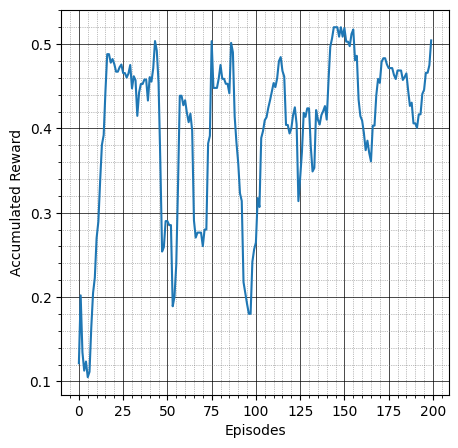

In [362]:
# instantiate grid world mdp object
gw2 = GridWorld(discount_factor=0.9)

# instantiate Q learner
QL = QLearner(gw2, alpha=0.3)

# training
episode_rewards = QL.train(episodes=200)

# policy extraction
pi = gw2.extract_policy()

print("-----------------------")
for y in range(gw2.height-1, -1, -1):
    for x in range(gw2.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards)


Episode# 0, length: 25, accumulated reward: 0.07976644307687256
-----------------------
 0.00  0.00  0.00  0.30 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 31, accumulated reward: 0.04239115827521624
-----------------------
 0.00  0.00  0.08  0.51 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 31, accumulated reward: -0.04239115827521624
-----------------------
 0.00  0.02  0.02  0.51 
 0.00  0.00  0.02 -0.30 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 28, accumulated reward: -0.058149737003040096
-----------------------
 0.01  0.01  0.02  0.51 
 0.00  0.00  0.00 -0.51 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 4, length: 19, accumulated reward: -0.15009463529699918
-----------------------
 0.01  0.01  0.01  0.51 
 0.00  0.00  0.00 -0.66 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 5, length: 35, accumulated reward: -0.02781283894436

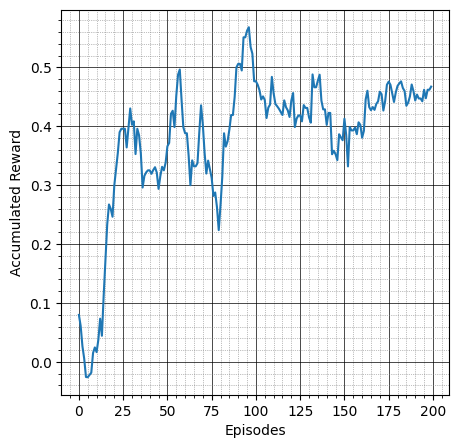

In [363]:
# instantiate grid world mdp object
gw3 = GridWorld(discount_factor=0.9)

# instantiate Q learner
QL2 = QLearner(gw3, alpha=0.3)

# training
episode_rewards = QL2.train(episodes=200, SARSA=True)

# policy extraction
pi = gw3.extract_policy()

print("-----------------------")
for y in range(gw3.height-1, -1, -1):
    for x in range(gw3.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards)

Testing Q learning and SARSA on the CliffWorld problem

In [408]:
class CliffWorld(MDP):

    def __init__(self, discount_factor=0.9, noise=0.01) :

        # initialise the set of all possible states, in this case tuples (x,y) of all grid cells, excluding walls
        # will use the example from lectures and tute week 7
        self.width = 6
        self.height = 4
 
        # specify walls/blocked states
        self.walls = []
 
        # specify terminal states
        self.terminal_states = [(1,0),(2,0),(3,0),(4,0),(5,0)] 

        # create a dummy terminal state which is the successor to all terminal states
        self.exit = (-1,-1)

        # specify initial state
        self.initial_state = (0,0)

        # list of all allowed states
        self.states = [self.exit]
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) not in self.walls:
                   self.states.append((x,y))

        # specify probability of splipping
        self.noise = noise

        # specify/enumerate the actions
        self.terminate = 0
        self.up = 1
        self.down = 2
        self.left = 3
        self.right = 4
        self.action_names = {self.up : 'up', self.down : 'down', self.left: 'left', self.right : 'right', self.terminate: 'end'}
        
        # set the discount factor
        self.gamma = discount_factor

        # specify rewards for transitioning into terminal states
        self.rewards =  {(1,0) : -100.0, (2,0) : -100.0, (3,0) : -100.0, (4,0) : -100.0, (5,0) : -1.0}

        # specify action cost 
        self.action_cost = -1.0

        # empty list for storing the discounted reward at each step opf the episode
        self.episode_discounted_rewards = []

        # initialize Q-function and value function
        self.Q = {}
        self.V = {}
        self.Vtemp = {}
        for state in (self.states):
            self.V[state] = 0.0
            self.Vtemp[state] = 0.0
            actions = self.get_actions(state)
            for action in actions:
                self.Q[(state, action)] = 0.0     


    def get_states(self):
        return self.states   


    def get_initial_state(self):
        return self.initial_state


    def get_terminal_states(self):
        return self.terminal_states


    def get_actions(self, state):

        actions = [self.terminate, self.up, self.down, self.left, self.right]
        if state is None:
            return actions
        
        valid_actions = []
        for action in actions:
            for (next_state, probability) in self.get_transitions(state, action):
                if probability > 0:
                    valid_actions.append(action)
                    break
                
        return valid_actions        

    
    # transition function
    def get_transitions(self, state, action):
        
        # probability of not slipping
        straight = 1 - 2*self.noise

        transitions = []
        (x,y) = state

        # if in terminal state or exit state, then only the 'terminate' action is available        
        if state in self.terminal_states or state == self.exit:
            if action == self.terminate:
                return [(self.exit, 1.0)] 
            else:
                return []
            
        # for non-terminal states, only up,down,left,right actions avaialable
        elif action == self.up:
            transitions.append(self.valid_add(state, (x,y+1), straight))
            transitions.append(self.valid_add(state, (x-1,y), self.noise))
            transitions.append(self.valid_add(state, (x+1,y), self.noise))

        elif action == self.down:
            transitions.append(self.valid_add(state, (x,y-1), straight))
            transitions.append(self.valid_add(state, (x-1,y), self.noise))
            transitions.append(self.valid_add(state, (x+1,y), self.noise))

        elif action == self.left:
            transitions.append(self.valid_add(state, (x-1,y), straight))
            transitions.append(self.valid_add(state, (x,y-1), self.noise))
            transitions.append(self.valid_add(state, (x,y+1), self.noise))

        elif action == self.right:
            transitions.append(self.valid_add(state, (x+1,y), straight))
            transitions.append(self.valid_add(state, (x,y-1), self.noise))
            transitions.append(self.valid_add(state, (x,y+1), self.noise))

        return transitions
    

    # reward function
    def get_rewards(self, state, action, next_state):
        if next_state in self.terminal_states:
            reward = self.rewards[next_state]
        elif next_state == self.exit:
            reward = 0.0                
        else:
            reward = self.action_cost

        # store discounted reward for the step
        step = len(self.episode_discounted_rewards)
        self.episode_discounted_rewards.append(reward * (self.gamma**step))

        return reward    


    def is_exit(self, state):
        return (state == self.exit)    


    def get_discount_factor(self):
        return self.gamma  

    
    def execute(self, state, action):
        # get all transitions
        transitions = self.get_transitions(state, action)
        states = [tr[0] for tr in transitions]
        probs = [tr[1] for tr in transitions]
        # sample from the transitions to get the next state state
        next_state = random.choices(states, weights=probs, k=1)[0]
        reward = self.get_rewards(state, action, next_state)
        return (next_state, reward)
    

    def valid_add(self, state, next_state, probability):

        # check if next state is a wall
        if next_state in self.walls:
            return (state, probability)

        # check if next state is off grid
        (x,y) = next_state
        if (x>=0 and x<=(self.width-1) and y>=0 and y<=(self.height-1)):
            return (next_state, probability)
        else:
            return (state, probability)


    def update_Q(self, state, action, Qnew):
        self.Q[(state, action)] = Qnew
    
    
    def update_V(self):
        # copy from Vtemp
        for state in self.states:
            self.V[state] = self.Vtemp[state]


    def update_V_from_Q(self):
        for state in self.states:
            actions = self.get_actions(state)
            self.V[state] =  max([self.Q[(state, action)] for action in actions])


    def extract_policy(self):
        # extract a policy using the Q function
        policy = {}
        for state in self.states:
            actions = self.get_actions(state)
            Qs = {}
            for action in actions:
                Qs[action] = self.Q[(state, action)]    

            policy[state] = self.action_names[max(Qs, key=lambda k:Qs[k])]
            
        return policy


#### Obtaining Cliffworld policy using value iteration

In [409]:
# instantiate cliff world mdp object
cw1 = CliffWorld(discount_factor=0.9, noise=0.000001)

value_iteration(cw1, num_iters=100, theta=0.0)

# policy extraction
pi1 = cw1.extract_policy()

print("-----------------------")
for y in range(cw1.height-1, -1, -1):
    for x in range(cw1.width):
        if (x,y) in pi1:
            print(f"{pi1[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

Iteration# 0
-----------------------
-1.00 -1.00 -1.00 -1.00 -1.00 -1.00 
-1.00 -1.00 -1.00 -1.00 -1.00 -1.00 
-1.00 -1.00 -1.00 -1.00 -1.00 -1.00 
-1.00  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 1
-----------------------
-1.90 -1.90 -1.90 -1.90 -1.90 -1.90 
-1.90 -1.90 -1.90 -1.90 -1.90 -1.90 
-1.90 -1.90 -1.90 -1.90 -1.90 -1.00 
-1.90  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 2
-----------------------
-2.71 -2.71 -2.71 -2.71 -2.71 -2.71 
-2.71 -2.71 -2.71 -2.71 -2.71 -1.90 
-2.71 -2.71 -2.71 -2.71 -1.90 -1.00 
-2.71  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 3
-----------------------
-3.44 -3.44 -3.44 -3.44 -3.44 -2.71 
-3.44 -3.44 -3.44 -3.44 -2.71 -1.90 
-3.44 -3.44 -3.44 -2.71 -1.90 -1.00 
-3.44  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 4
-----------------------
-4.10 -4.10 -4.10 -4.10 -3.44 -2.71 
-4.10 -4.10 -4.10 -3.44 -2.71 -1.90 
-4.10 -4.10 -3.44 -2.71 -1.90 -1.00 
-4.10  0.00  0.0

#### Obtaining Cliffworld policy using Q learning

Episode# 0, length: 8, accumulated reward: -57.82969000000001
-----------------------
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 28, accumulated reward: -15.814973700304009
-----------------------
 0.00 -0.01  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 15, accumulated reward: -32.876792454961006
-----------------------
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 3, accumulated reward: -91.0
-----------------------
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.03  0.00  0.00  0.00  0.00  0.00 
-

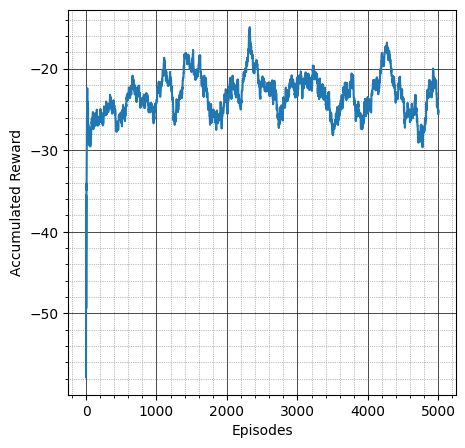

In [410]:
cw2 = CliffWorld(discount_factor=0.9, noise=0.000001)

# instantiate Q learner
QL1 = QLearner(cw2, epsilon=0.2, alpha=0.01)

# training
episode_rewards = QL1.train(episodes=5000, SARSA=False)

# policy extraction
pi1 = cw2.extract_policy()

print("-----------------------")
for y in range(cw2.height-1, -1, -1):
    for x in range(cw2.width):
        if (x,y) in pi1:
            print(f"{pi1[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards, window_size=150)

#### Obtaining Cliffworld policy using SARSA

Episode# 0, length: 8, accumulated reward: -57.82969000000001
-----------------------
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 14, accumulated reward: -35.418658283290014
-----------------------
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 29, accumulated reward: -15.233476330273607
-----------------------
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 13, accumulated reward: -38.242953648100006
-----------------------
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02 -0.01  0.00  0.00  0.00  0.00 
-0.02 -0.01  0.00  0.00  0.00  0.00 
-0.03  0.00  0.00  0.00

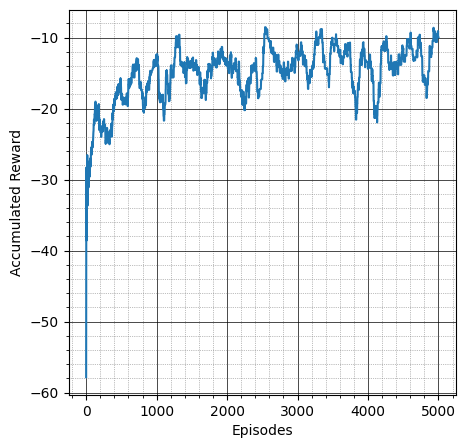

In [411]:
cw3 = CliffWorld(discount_factor=0.9, noise=0.000001)

# instantiate Q learner
QL2 = QLearner(cw3, epsilon=0.2, alpha=0.01)

# training
episode_rewards = QL2.train(episodes=5000, SARSA=True)

# policy extraction
pi2 = cw3.extract_policy()

print("-----------------------")
for y in range(cw3.height-1, -1, -1):
    for x in range(cw3.width):
        if (x,y) in pi2:
            print(f"{pi2[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards, window_size=100)